# Chamber Temp Calculation (Huiting)

This notebook is the essentially unmodified version of Huiting's chamber temp calculation code, originally found in `/H20/2020/chamber temp sept17.ipynb`

In [3]:
import h5py
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import cm # this imports different "color maps" for use on contour plots
from mpl_toolkits.mplot3d import Axes3D # used for 3D plotting
from scipy import optimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc #parameters
# import pandas as pd
# get_ipython().run_line_magic('matplotlib', 'notebook')
import os.path
import time

P211font = {'weight':'normal', 'size':14, 'color':'black', 'style' : 'italic', 'family' : 'serif'}
P211axes = {'weight':'normal', 'size':12, 'color':'black', 'family' : 'serif'}

Tbg = 150 #background temp from chamber temp contour
# p = 3.8*133.322 #pressure of chamber (Pa)
kair = 0.013 #W/(m*K)
kcu = 385
ksteel = 50.2

bucket_radius = .367
bucket_height = 0.1969
plate_outer_radius = .665
plate_inner_radius = .665
plate_outer_height = 0.6102362
plate_inner_height = plate_outer_height
N=64
bucket_temp = 73
#plate_temp = 273+90 #12 radius
plate_temp=315.5 #13 radius
boundary_temp = 289

def thermal_conductivity(r, z, T, N):
    if r< bucket_radius*N and z < bucket_height*N:
        k[r][z] = ksteel
        return 1
#     elif r< cone_skirt_inner_radius*N and z< b:
#        T[r][z]=bucket_temp
#        return 1
    elif r< plate_inner_radius*N and z> plate_inner_height*N:
        k[r][z]=kcu
        return 1
    elif plate_inner_radius*N<r<plate_outer_radius*N and z>plate_outer_height*N:
        k[r][z]=kcu
        return 1
    else:
        k[r][z]=0.00014*T[r][z]**0.918
        return 0 

# def thermal_conductivity (r,z,T,N):
#     k[r][z]=0.00014*T[r][z]**0.918
        
def source_function (r,z):
    s[r][z] = 0
        

def boundaryCondition1(r,z,N,bucket_temp,plate_temp,boundary_temp):
#     cone_skirt_radius = .627
#     cone_skirt_height = .25
    #     b = (-1/np.tan(np.pi/3.14))*r + (cone_skirt_height + cone_skirt_inner_radius/np.tan(np.pi/3.14))*N
    #     if r< cone_skirt_radius*N and z < cone_skirt_height*N:
    #        T[r][z]=bucket_temp
    #        return 1
    if r<bucket_radius*N and z<bucket_height*N:
        T[r][z] = bucket_temp
        return 1
    elif r<plate_inner_radius*N and z>plate_inner_height*N:
        T[r][z]=plate_temp
        return 1
#     elif plate_inner_radius*N<r<plate_outer_radius*N and z>plate_outer_height*N:
#         T[r][z]=plate_temp
#         return 1
#     elif r==N-2:
#         T[r][z]=boundary_temp
#         return 1
    elif r==N-1:
        T[r][z]=boundary_temp
        return 1
    elif z==0:
        T[r][z]=T[r][1]
    elif z==N-1:
        T[r][z]=T[r][N-2]
        return 1
    else:
        return 0 


In [4]:
k = np.zeros ((N,N))
s = np.zeros ((N,N))
kradd = np.zeros ((N,N))
krsub = np.zeros ((N,N))
kzadd = np.zeros ((N,N))
kzsub = np.zeros ((N,N))
Ts = np.zeros ((N,N))
T = np.zeros((N,N))
boundr = np.zeros(N)
boundz = np.zeros(N)


for z in range(0,N): 
    for r in range(0,N):                     
        T[r][z]=Tbg
        boundaryCondition1(r,z,N,bucket_temp,plate_temp,boundary_temp)
        


/var/folders/r1/3pwt_y8x3m39pdps_fxcbw480000gn/T/ipykernel_96092/3938616091.py:27: RuntimeWarning: invalid value encountered in scalar divide
  a1 = 2*(1+1/2/r)*k[r+1][z]/(k[r][z]+k[r+1][z])
/var/folders/r1/3pwt_y8x3m39pdps_fxcbw480000gn/T/ipykernel_96092/3938616091.py:36: RuntimeWarning: invalid value encountered in scalar divide
  Ts[r][z]=s[r][z]/k[r][z]/Sum
/var/folders/r1/3pwt_y8x3m39pdps_fxcbw480000gn/T/ipykernel_96092/3938616091.py:28: RuntimeWarning: invalid value encountered in scalar divide
  a2 = 2*(1-1/2/r)*k[r-1][z]/(k[r][z]+k[r-1][z])


64^2 cells, 10000 iterations took 141.6494381427765 seconds.


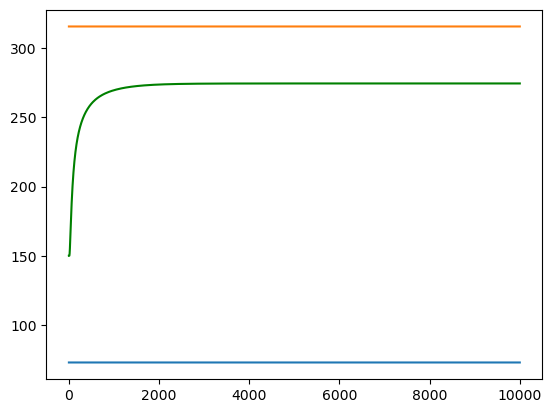

In [5]:
T1 = []
T2 = []
T3 = []

start_time = time.time()

iterations = int(10000)

for _ in range(iterations): 
    
    for z in range(N):                    #r=N for N*N geometry
        for r in range(N):                     #r=(N+1)/2 for Nr*N geometry
            thermal_conductivity(r,z,T,N)
#             boundaryCondition1(r,z,N,bucket_temp,plate_temp,boundary_temp)
    for z in range (0,N-1):                     # Determine all transport coefficients, without 1/4,3/4 correction
        a1=8*k[1][z]/(k[0][z]+k[1][z])
        b1=2*k[0][z+1]/(k[0][z]+k[0][z+1])
        b2=2*k[0][z-1]/(k[0][z]+k[0][z-1])
        Sum=a1+b1+b2
        kradd[0][z]=a1/Sum
        krsub[0][z]=0
        kzadd[0][z]=b1/Sum
        kzsub[0][z]=b2/Sum
        Ts[0][z]=s[0][z]/k[0][z]/Sum
        # for r in range (1,N-2):
        for r in range (1,N-1):   
            a1 = 2*(1+1/2/r)*k[r+1][z]/(k[r][z]+k[r+1][z])
            a2 = 2*(1-1/2/r)*k[r-1][z]/(k[r][z]+k[r-1][z])
            b1 = 2*k[r][z+1]/(k[r][z]+k[r][z+1])
            b2 = 2*k[r][z-1]/(k[r][z]+k[r][z-1])
            Sum=a1+a2+b1+b2
            kradd[r][z]=a1/Sum
            krsub[r][z]=a2/Sum
            kzadd[r][z]=b1/Sum
            kzsub[r][z]=b2/Sum
            Ts[r][z]=s[r][z]/k[r][z]/Sum
        
    T=kradd*np.roll(T,-1,axis=0)+krsub*np.roll(T,1,axis=0)+kzadd*np.roll(T,-1,axis=1)+kzsub*np.roll(T,1,axis=1)+Ts
    
    for z in range(N):
        for r in range(N):
            boundaryCondition1(r,z,N,bucket_temp,plate_temp,boundary_temp)

#     if r< bucket_radius*N and z < bucket_height*N:
#         T[r][z] = bucket_temp
#     elif r< plate_inner_radius*N and z> plate_inner_height*N:
#         T[r][z]=plate_temp
#     elif plate_inner_radius*N<r<plate_outer_radius*N and z>plate_outer_height*N:
#         T[r][z]=plate_temp
#     elif r==N-1:
#         T[r][z]=boundary_temp
#     elif r==N-2:
#         T[r][z]=boundary_temp

    T1.append(T[0][32])
    T2.append(T[1][0])
    T3.append(T[32][45])

print("%s^2 cells, %s iterations took %s seconds." %(N, iterations, time.time() - start_time))

plt.plot (T1,color='green')
plt.plot (T2,label='blue')
plt.plot (T3,label='red')
plt.show()

# np.savetxt('/Users/lucretialiu/Desktop/chinlab/levitation 2020/12-13 scan/dimensionless temp/r=%s_dr=%s.txt'%(PMMAradius,round(delta*10**6,3)),T)


(64, 63)
73.0
315.5
[ 73.      93.4285 113.857  134.2855 154.714  175.1425 195.571  215.9995
 236.428  256.8565 277.285  297.7135 318.142  338.5705 358.999 ]


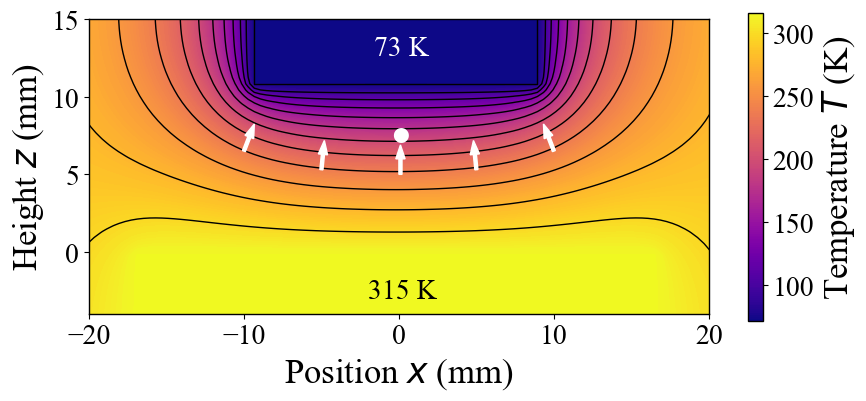

In [6]:
# plt.imshow(T.T,cmap='plasma')
#print(T.T)

#file = open("C:\\Users\\kelse\\OneDrive\\Documents\\Autumn 2020\\T_TMatrix.txt", "w") #a=append,w=write,r=read
#file.write(print(T.T))
#file.close()

#np.savetxt('C:\\Users\\kelse\\OneDrive\\Documents\\Autumn 2020\\T_TMatrix.txt', T.T)
    
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['font.size'] = 20
#mpl.rcParams['font.weight'] = 'bold'
flip= np.flip(T.T, 1)

flip_63=np.delete(flip, obj=63, axis=1)
print(flip_63.shape)


a=np.concatenate((flip_63, T.T), axis=1)

b=np.flip(a, 0)



#max =np.max(b)
#print(max)

#y = np.arange(0,25.408,0.397)
#x = np.arange(-25.2095,25.2095, 0.397)
#x = np.arange(-24.256,24.256, 0.379)
y = np.arange(-9.4,16.008,0.397)
x = np.arange(-25.2095,25.2095, 0.397)

xx, yy = np.meshgrid(x, y)
plt.figure(figsize=(10,4))
cs = plt.contourf(xx,yy,b,levels=200,cmap='plasma')
#plt.colorbar(ticks = [100, 150, 200, 250, 300, 350])
plt.colorbar(ticks = [100, 150, 200, 250, 300, 350]).set_label(label='Temperature $T$ (K)',size=25)

#level=np.linspace(0.0002,0.0038,19)


plt.gca().set_aspect('equal')
#plt.tight_layout()

#range is 72 to 363
cs2 = plt.contour(xx,yy,b,levels=np.linspace(np.min(T),358.999,15),colors='black',linewidths=1)

print(np.min(T))
print(np.max(T))
#plt.imshow(a, cmap = 'plasma', norm = mpl.colors.Normalize(vmin = 77, vmax = 410), )

#plt.contour(T.T,14,cmap='plasma')
#plt.contour(a,14, linewidths=0.5, cmap= 'Greys', norm = mpl.colors.Normalize(vmin=-100000000000000000, vmax=410))
#plt.xlim()
#plt.ylim()
plt.text(-2,-3, '315 K')
plt.text(-1.6,12.7, '73 K', color='white')
plt.text(-1,7.2, '.', color='white', size=100)


#plt.xlabel('Displacement $x$ (mm)',fontsize=25)
plt.xlabel('Position $x$ (mm)',fontsize=25)
plt.ylabel(r'Height $z$ (mm)', fontsize=25)



print(cs2.levels)

plt.ylim(-4,15)
plt.xlim(-20,20)

plt.arrow(0.1,5, 0, 1, width=0.2, color='white', zorder=10)
plt.arrow(5.0,5.3, -0.1, 0.99, width=0.2, color='white', zorder=11)
plt.arrow(-5,5.3, 0.1, 0.99, width=0.2, color='white', zorder=12)
plt.arrow(10,6.5, -0.35, 0.91, width=0.2, color='white', zorder=13)
plt.arrow(-10,6.5, 0.35, 0.91, width=0.2, color='white', zorder=14)

#print(T[63][63])
#print(b[51][63])


182.35369070027946
182.38289762054413
182.4708762337301
182.61886157051885
171.8612489960999
192.26114256317837


(190.0, 192.0)

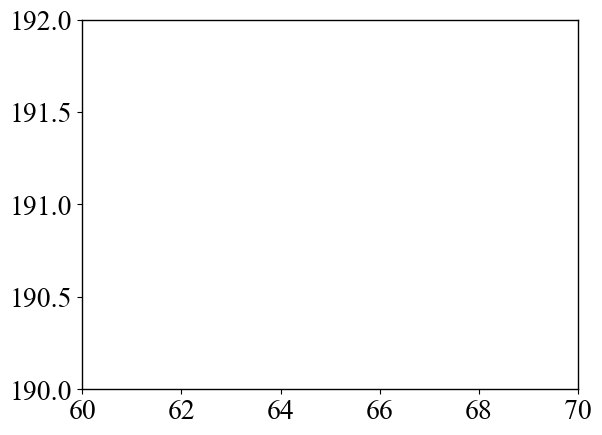

In [7]:
#print(a[18,61])
#print(a[18,62])
print(a[20,63])
print(a[20,64])
print(a[20,65])
print(a[20,66])

print(a[19,64])
print(a[21,64])


plt.plot(a[18,:])

plt.xlim(60,70)
plt.ylim(190, 192)



73.0


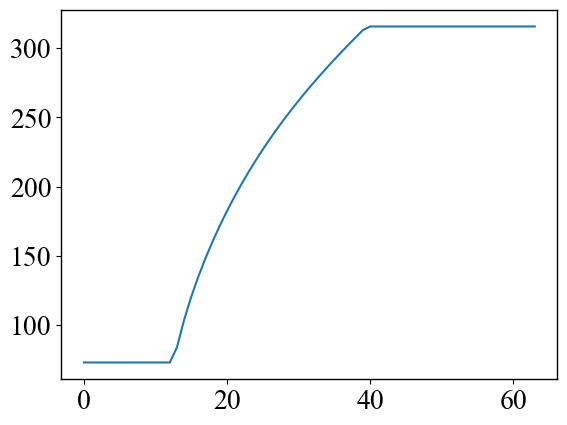

In [8]:
print(b[51,63])

plt.plot(a[:,63])

In [ ]:
dx=0.397
dy=0.397
#mm
grad_x=np.gradient(b, dx, axis=1)
grad_y=np.gradient(b, dy, axis=0)
#print(grad_x)
#print(grad_y)
#plt.imshow(grad_x, cmap = 'gist_ncar')
plt.contourf(grad_x, cmap='gist_ncar', levels=np.linspace(-10,10, 50))
#plt.imshow(grad, cmap = 'plasma', norm = matplotlib.colors.Normalize(vmin = 77, vmax = 410), )
plt.colorbar()
#K/mm
#plt.contour(T.T,14,cmap='plasma')
#plt.contour(grad,14, linewidths=0.5, cmap= 'Greys', norm = matplotlib.colors.Normalize(vmin=-100000000000000000, vmax=410))

In [ ]:
# dens = 997 #density of nitrogen in kg/m^3
Rc = .062364 #Boltzman constant?, units energy/temp #does not look like Boltzman constant
mfpconstant = 428081 #the constant part of the denominator of calculating mean free path. Has units of m^2
kb = 1.38065 * 10**(-23) ## Boltzmann constant metres^2 * kg * seconds^(-2) * Kevlin^(-1)
mN = 2.3*10**(-26) # mass of a nitrogen molecule, kilograms
#calculate Mean-Free-Path of air for a given temperature and pressure (Given in meters)
def mfp(T,P):
    return Rc*T/(mfpconstant*P)
#calculate thermal conductivity for a given temperature (given in mW/(m*K))


##### calculate thermophoretic constant given the Knudsen Number
def Fth(Kn):
    return 1.89 * ((Kn**2)-.115*Kn+.00611)/((Kn**2)+.5284*Kn+.6508) 
def thermc(T):
    return -0.00000000000000000375*T**(6)+0.00000000000001909230*T**(5)-0.00000000004016396062*T**(4)+0.00000004901175449123*T**(3) \
        -0.000044075614398888*T**(2)+0.0766069577308689*T+24.3560822452597
#given a temperature and gradient, calculate the force without thermophoretic constant or radius (milliNewtons/m^2)
def BasicForce(T,grad):
    return thermc(T)*grad/np.sqrt(2*kb*T/mN)
#calculates total force given a temperature, gradient, pressure, and radius
#I'm pretty sure this gives the force in Newtons
def ThermForce(T,grad,P,r):
    return -Fth(mfp(T,P)/r)*BasicForce(T,grad)*(r**2)
P1=3.8
P2=5.0
#Originally calculated with r=12*10**(-6)
r_force=ThermForce(b,grad_x,P2,13.235*10**(-6))
y_force=ThermForce(b,grad_y,P2,13.235*10**(-6))
#print(r_force)

In [ ]:
#plt.imshow(r_force, cmap='plasma')
#plt.colorbar()
y = np.arange(-9.4,16.008,0.397)
x = np.arange(-25.2095,25.2095, 0.397)

xx, yy = np.meshgrid(x, y)

plt.contourf(xx, yy, y_force, 20)

In [ ]:
nx, ny = np.meshgrid(x,y)
plt.contourf(xx, yy, r_force, 100)
#plt.clim(-0.3*1e-10,0.3*1e-10)
plt.colorbar(label='Force (N)')
plt.set_cmap('inferno')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

In [ ]:
triangle = np.array([[0, 7.8], [-8.81,0], [8.81,0]])
plt.contourf(xx, yy, r_force, 1000)
plt.clim(-0.3*1e-10,0.3*1e-10)
#t1 = plt.Polygon(triangle[:3,:], color='blue')
#plt.gca().add_patch(t1)
plt.colorbar(label='Force (N)')
plt.set_cmap('inferno')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
#plt.set_cmap('inferno')

In [ ]:
plt.plot(r_force[51,:])
plt.xlim(62,64)
print(r_force[51,62])
print(r_force[51,63])
print(r_force[51,64])



In [ ]:
plt.plot(y_force[43, :])

In [ ]:
plt.plot(r_force[:,64])
print(r_force[43,64])


In [ ]:
#Original
Tz=np.zeros((64))
l = np.array(range(64))*0.397
for i in range (0,64): 
    Tz[i]=T.T[i,0]
revTz=np.flipud(Tz)
Tzflat=revTz
print (Tzflat)
dTz = np.gradient(revTz)
dTzfalt=dTz
print (dTzfalt)

force = np.zeros((64))
thermc1 = np.zeros((64))
Fth1 = np.zeros ((64))
BasicForce1 = np.zeros ((64))
#p=3.8
#s=0.000012
p=5.1
s=0.000013235
for i in range (0,64): 
    force[i] = ThermForce (revTz[i],(dTz[i]/0.397),p,s)
    thermc1[i] = thermc (revTz[i])
    Fth1[i] = Fth (mfp(revTz[i],p)/s)
    BasicForce1 [i] = BasicForce (revTz[i],dTz[i]/0.397)
plt.plot(revTz,'bo')
# plt.plot(l,force)
m=1200*(4/3)*np.pi*s**3
g=9.8
# plt.hlines(m*g,0,30,linestyle="-")
fig1 = plt.figure ()
ax1 = fig1.add_subplot(111)
ax1.plot (l,force)
ax1.hlines (m*g,0,30,linestyle="-")
#plt.axis ([20.155,20.17, 0e-10,1e-10])
# fig1.savefig('photo6.png')


In [ ]:
plt.imshow(y_force, cmap='plasma')
plt.colorbar()

In [ ]:
plt.plot(y_force[:,64])

In [ ]:
print("52,63=",y_force[52,63])
print("52,64=",y_force[52,64])
print("52,65=",y_force[52,65])
print("51,63=",y_force[51,63])
print("51,64=",y_force[51,64])
print("51,65=",y_force[51,65])
print("50,63=",y_force[50,63])
print("50,64=",y_force[50,64])
print("50,65=",y_force[50,65])
print("mg=", m*g)
print(y_force.shape)

In [ ]:
#Checking 
Tz=np.zeros((64))
l = np.array(range(64))*0.397
for i in range (0,64): 
    Tz[i]=T.T[i,0]
revTz=np.flipud(Tz)
Tzflat=revTz
print (Tzflat)
dy=0.397
dTz = np.gradient(revTz, dy, axis=0)
dTzfalt=dTz
print (dTzfalt)

force = np.zeros((64))
thermc1 = np.zeros((64))
Fth1 = np.zeros ((64))
BasicForce1 = np.zeros ((64))
p=3.8
s=0.000012
for i in range (0,64): 
    force[i] = ThermForce (revTz[i],dTz[i],p,s)
    thermc1[i] = thermc (revTz[i])
    Fth1[i] = Fth (mfp(revTz[i],p)/s)
    BasicForce1 [i] = BasicForce (revTz[i],dTz[i])
plt.plot(revTz,'bo')
# plt.plot(l,force)
m_1=1200*(4/3)*np.pi*s**3
g=9.8
# plt.hlines(m*g,0,30,linestyle="-")
fig1 = plt.figure ()
ax1 = fig1.add_subplot(111)
ax1.plot (l,force)
ax1.hlines (m*g,0,30,linestyle="-")
#plt.axis ([10,30, 0e-10,1e-10])
# fig1.savefig('photo6.png')


In [ ]:
print(y_force[51,63])
print(y_force[51,64])
print(y_force[51,65])
print(force.shape)
print(m_1*g/y_force[51,63])
print(y_force[:,63].shape)
print(y_force[:,63])
print(force/y_force[:,63])

In [ ]:
#dif=np.zeros((64,1))

#for i in range (0,64):
    #dif [i]=force[i]/y_force[:,63][i]
#print(dif)

In [ ]:
ar=np.column_stack((force, y_force[:,63]))
#print(ar)
print(ar.shape)

for i, j in ar:
    if j > 0:
        factor=i/j
        print(factor)
        

In [ ]:
#at=np.column_stack((r_force[:,63], y_force[:,63]))
#print(at)
#print(at.shape)

#for i, j in at:
    #if j > 0:
        #if i > 0:
            #t_force=(i**2 + j**2)**(-1/2)
            #print(t_force)

In [ ]:
t_force2=r_force**2 + y_force**2
print(t_force2)
print(t_force2.shape)
t_force=t_force2**(1/2)

In [ ]:
plt.imshow(t_force, cmap='plasma')
#plt.ylim(51,52)
plt.colorbar()

In [ ]:
plt.plot(t_force[:,63])
plt.xlim(48,54)


In [ ]:
##System Information

#Chamber: Gap=11 mm, 
#Particle Coordinates: Z=51, r=63
#Top Bucket: T=73K, Boundary at Z=52, 
#Bottom Bucket: T=363K, Boundary at Z=24,

In [ ]:
plt.plot((t_force[43,:])/(m*g))
#plt.xlim(62,64)
print(t_force[51,62])
print(t_force[51,64])

In [ ]:
plt.plot((y_force[43,:])/(m*g))
#Print((y_force[43,:]))
plt.xlim(40,85)
print(r_force[43,64])

In [ ]:
plt.plot((y_force[44,:])/(m*g))
plt.xlim(40,85)

In [ ]:
plt.plot((y_force[45,:])/(m*g))
plt.xlim(40,85)

In [ ]:
plt.plot((r_force[43,:])/(m*g))
plt.xlim(63,68)
plt.ylim(-0.02,0.02)

In [ ]:
Norm_Force= r_force[43,:]/y_force[43,63]
plt.plot(Norm_Force)

In [ ]:
plt.plot(Norm_Force)
plt.xlim(50,76)
plt.ylim(-0.02,0.02)

In [ ]:
plt.plot(Norm_Force)
plt.xlim(62,64)
plt.ylim(-0.02,0.02)
print(Norm_Force[62])
print(Norm_Force[64])

slope=(Norm_Force[62]-Norm_Force[64])/2
print(slope/0.397)

In [ ]:
plt.plot(r_force[52,:]/(m*g))
plt.xlim(50,76)
plt.ylim(-0.0002,0.0002)

In [ ]:
norm_g=r_force[51,:]/(m*g)

plt.plot(norm_g)
plt.xlim(50,76)
plt.ylim(-0.02,0.02)
print(norm_g[62])
print(norm_g[64])

slope_r=(norm_g[62]-norm_g[64])/2
print(slope_r/0.397)
print(slope/0.397)

In [ ]:
plt.plot(r_force[50,:]/(m*g))
plt.xlim(50,76)
plt.ylim(-0.02,0.02)

In [ ]:
##Normalized Calculations with Experimental Data
Factor=0.9469772686914929

plt.plot(y_force[43,:]/Factor)
print(y_force[43,63]/Factor)

In [ ]:
plt.plot(r_force[43,:]/Factor)
print(r_force[43,64]/Factor)

In [ ]:
plt.plot(y_force[:,63]/Factor)

In [ ]:
plt.plot(r_force[:, 64]/Factor)
print(r_force[43, 64]/Factor)

In [ ]:
plt.plot(r_force[43,:]/(y_force[43,:]), marker='.')
plt.xlim(60, 66)
plt.ylim(-0.02,0.02)
